<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/15_Application_Architectures_Deep_Dive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Application Architectures Deep Dive

In this chapter, we're going to fill in all the missing details on how fastai's application models work and show you how to build the models they use.

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 4.9 MB/s 
     |████████████████████████████████| 4.9 MB 43.9 MB/s 
     |████████████████████████████████| 1.3 MB 12.8 MB/s 
     |████████████████████████████████| 431 kB 58.2 MB/s 
     |████████████████████████████████| 163 kB 54.6 MB/s 
     |████████████████████████████████| 115 kB 56.6 MB/s 
     |████████████████████████████████| 212 kB 48.6 MB/s 
     |████████████████████████████████| 127 kB 66.7 MB/s 
     |████████████████████████████████| 6.6 MB 19.7 MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

# Computer Vision

For computer vision application we use the functions vision_learner and unet_learner to build our models, depending on the task. In this section we'll explore how to build the Learner objects we used in Parts 1 and 2 of this book.

### vision_learner

Let's take a look at what happens when we use the vision_learner function. We begin by passing this function an architecture to use for the body of the network. Most of the time we use a ResNet, pretrained weights are downloaded as required and loaded into the ResNet.

Then, for transfer learning, the network needs to be cut. This refers to slicing off the final layer, which is only responsible for ImageNet-specific categorization. In fact, we do not slice off only this layer, but everything from the adaptive average pooling layer onwards. The reason for this will become clear in just a moment. Since different architectures might use different types of pooling layers, or even completely different kinds of heads, we don't just search for the adaptive pooling layer to decide where to cut the pretrained model. Instead, we have a dictionary of information that is used for each model to determine where its body ends, and its head starts. We call this model_meta—here it is for resnet-50:

In [3]:
model_meta[resnet50]

{'cut': -2,
 'split': <function fastai.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

If we take all of the layers prior to the cut point of -2, we get the part of the model that fastai will keep for transfer learning. Now, we put on our new head. This is created using the function create_head:

In [4]:
create_head(20,2)

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=40, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

With this function you can choose how many additional linear layers are added to the end, how much dropout to use after each one, and what kind of pooling to use. By default, fastai will apply both average pooling, and max pooling, and will concatenate the two together (this is the AdaptiveConcatPool2d layer). This is not a particularly common approach, but it was developed independently at fastai and other research labs in recent years, and tends to provide some small improvement over using just average pooling.

***fastai*** is a bit different from most libraries in that by default it adds two linear layers, rather than one, in the CNN head. The reason for this is that transfer learning can still be useful even, as we have seen, when transferring the pretrained model to very different domains. However, just using a single linear layer is unlikely to be enough in these cases; we have found that using two linear layers can allow transfer learning to be used more quickly and easily, in more situations.

Let's now take a look at what unet_learner do for segmentation problems

# unet_learner

One of the most interesting architectures in deep learning is the one that we used for segmentation. Segmentation is a challenging task, because the output required is really an image, or a pixel grid, containing the predicted label for every pixel. There are other tasks that share a similar basic design, such as increasing the resolution of an image (super-resolution), adding color to a black-and-white image (colorization), or converting a photo into a synthetic painting (style transfer). In each case, we are starting with an image and converting it to some other image of the same dimensions or aspect ratio, but with the pixels altered in some way. We refer to these as generative vision models.

Naturally, we do this with a neural network! So we need some kind of layer that can increase the grid size in a CNN. One very simple approach to this is to replace every pixel in the 7×7 grid with four pixels in a 2×2 square. Each of those four pixels will have the same value—this is known as nearest neighbor interpolation. PyTorch provides a layer that does this for us, so one option is to create a head that contains stride-1 convolutional layers (along with batchnorm and ReLU layers as usual) interspersed with 2×2 nearest neighbor interpolation layers.Another approach is to replace the nearest neighbor and convolution combination with a transposed convolution, otherwise known as a stride half convolution. This is identical to a regular convolution, but first zero padding is inserted between all the pixels in the input. See the [arithmetic convolution paper](https://arxiv.org/abs/1603.07285) for a visual inspection.The result of this is to increase the size of the input. You can try this out now by using fastai's ConvLayer class; pass the parameter transpose=True to create a transposed convolution, instead of a regular one, in your custom head.

Neither of these approaches, however, works really well. The problem is that our 7×7 grid simply doesn't have enough information to create a 224×224-pixel output. It's asking an awful lot of the activations of each of those grid cells to have enough information to fully regenerate every pixel in the output. The solution to this problem is to use skip connections, like in a ResNet, but skipping from the activations in the body of the ResNet all the way over to the activations of the transposed convolution on the opposite side of the architecture. This approach, was developed by Olaf Ronneberger, Philipp Fischer, and Thomas Brox in the 2015 paper "U-Net: Convolutional Networks for Biomedical Image Segmentation". Although the paper focused on medical applications, the U-Net has revolutionized all kinds of generative vision models.

With this architecture, the input to the transposed convolutions is not just the lower-resolution grid in the preceding layer, but also the higher-resolution grid in the ResNet head. This allows the U-Net to use all of the information of the original image, as it is needed. One challenge with U-Nets is that the exact architecture depends on the image size. fastai has a unique DynamicUnet class that autogenerates an architecture of the right size based on the data provided.

We will show now how it can be use for a driving segmentation data set

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,time
0,2.912031,2.309602,01:16


epoch,train_loss,valid_loss,time
0,1.800495,1.583928,01:16
1,1.571422,1.470469,01:15
2,1.414757,1.303472,01:16
3,1.303311,1.124085,01:14


In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

We can visualize how well it achieved its task, by asking the model to color-code each pixel of an image. As you can see, it nearly perfectly classifies every pixel in every object. For instance, notice that all of the cars are overlaid with the same color and all of the trees are overlaid with the same color (in each pair of images, the lefthand image is the ground truth label and the right is the prediction from the model):

# NLP and Tabular

Note that as part of implementing what was showed during the course, the NLP and Tabular notebooks I edited show how it can be use on you own dataset:



*   [NLP notebook](https://github.com/afortuny/DeepLearningFastAI/blob/main/11_nlp.ipynb)
*   [Tabular Notebook](https://github.com/afortuny/DeepLearningFastAI/blob/main/10_tabular.ipynb)

Even more generic problems have been implemented on my end, with siamese networks for [whale detection](https://github.com/afortuny/DeepLearningFastAI/blob/main/12_midlevel_data_API.ipynb) and [categorical embeddings for pump failure prediction.](https://github.com/afortuny/DeepLearningFastAI/blob/main/Failing%20Water%20Pupm%20Detection%20with%20Tabular%20Learner.ipynb)




# Moving forward

As you can see, the details of deep learning architectures need not scare you now. You can look inside the code of fastai and PyTorch and see just what is going on. More importantly, try to understand why it's going on. Take a look at the papers that are being referenced in the code, and try to see how the code matches up to the algorithms that are described.

Now that we have investigated all of the pieces of a model and the data that is passed into it, we can consider what this means for practical deep learning. If you have unlimited data, unlimited memory, and unlimited time, then the advice is easy: train a huge model on all of your data for a really long time. But the reason that deep learning is not straightforward is because your data, memory, and time are typically limited. If you are running out of memory or time, then the solution is to train a smaller model. If you are not able to train for long enough to overfit, then you are not taking advantage of the capacity of your model.

So, step one is to get to the point where you can overfit. Then the question is how to reduce that overfitting. 

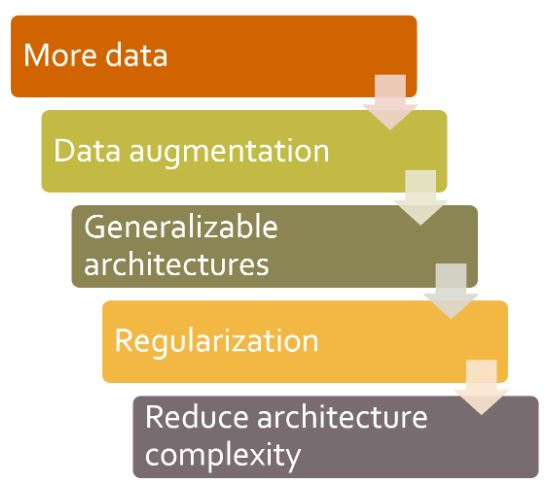

Many practitioners, when faced with an overfitting model, start at exactly the wrong end of this diagram. Their starting point is to use a smaller model, or more regularization. Using a smaller model should be absolutely the last step you take, unless training your model is taking up too much time or memory. Reducing the size of your model reduces the ability of your model to learn subtle relationships in your data.

Instead, your first step should be to seek to create more data. That could involve adding more labels to data that you already have, finding additional tasks that your model could be asked to solve (or, to think of it another way, identifying different kinds of labels that you could model), or creating additional synthetic data by using more or different data augmentation techniques. Thanks to the development of Mixup and similar approaches, effective data augmentation is now available for nearly all kinds of data.

Once you've got as much data as you think you can reasonably get hold of, and are using it as effectively as possible by taking advantage of all the labels that you can find and doing all the augmentation that makes sense, if you are still overfitting you should think about using more generalizable architectures. For instance, adding batch normalization may improve generalization.

If you are still overfitting after doing the best you can at using your data and tuning your architecture, then you can take a look at regularization. Generally speaking, adding dropout to the last layer or two will do a good job of regularizing your model. However, as we learned from the story of the development of AWD-LSTM, it is often the case that adding dropout of different types throughout your model can help even more. Generally speaking, a larger model with more regularization is more flexible, and can therefore be more accurate than a smaller model with less regularization.

Only after considering all of these options would we recommend that you try using a smaller version of your architecture.